# K Means 

* KMeans is an unsupervised machine learning method that clusters data into `k` different clusters.
* Each sample is assigned to the cluster with the nearest mean, and then the means (centroids) are clustered and updated during an iterative optimization process.

<br>

[![image.png](https://i.postimg.cc/FFJYDW4y/image.png)](https://postimg.cc/K4xcY54j)

In [1]:
from typing import Any, Optional, Union

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

from run_algos import utils


# Black code formatter (Optional)
%load_ext lab_black

## Steps Required To Build KMeans From Scratch

* Initialize the centers of the clusters randomly.
* Repeat the following steps until the clusters converge (i.e the centroids of the clusters are no longer changing)
  * Update the cluster labels: assign points to the nearest cluster's centroid.
  * Update the cluster's centroids: set the new center of the mean of each cluster.


### Eucledean Distance (d(a, b))

$$d(a, b) = \sqrt{\sum_{i}^N{(a_{i} - b_{i}) ^2}}$$

### 1. Init

- Initialize the hyperparameters:
  - Number of clusters
  - Maximum number of iterations.
  - The centroids


### 2. Fit 

- Initialize the centroids randomly.
- Initialize the parameters required for calculations.

### 3. Predict

- Update the labels by assigning the nearest centroid to the data points using the `Eucledean` distance or any distance metric.
  - Create clusters.
- Re-calculate the centroids. i.e calculate the average position of the labels in the cluster.
- Check for divergence. i.e using a distance metric (Eucledean distance), check that the centroids are no longer changing.
- The algorithm can also be stopped if the num of iterations (max_iter) has been reached.

In [2]:
class KMeans:
    """This class is used for creating K-clusters from scratch."""

    def __init__(
        self, K: int = 5, max_iters: int = 300, plot_steps: bool = False
    ) -> None:
        self.K = K
        self.max_iters = max_iters
        self.plot_steps = plot_steps
        self.clusters = [[] for _ in np.arange(self.K)]  # type: ignore
        self.centroids = None

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(K={self.K}, max_iters={self.max_iters})"

    def fit(self, X: npt.ArrayLike, y: npt.ArrayLike = None) -> npt.NDArray[np.int_]:
        """This is used to train the model."""
        n_samples = X.shape[0]

        # Init centroids randomly
        random_idxs = np.random.choice(n_samples, self.K, replace=False)
        self.centroids = [X[idx] for idx in random_idxs]  # type: ignore

        # Optimize the algorithm:
        # 1: Create clusters by assigning the samples to the closest centroid.
        # 2: Update the centroids and compare the new and old centroids
        # 3: Check if the algorithm has converged. i.e whether the centroids
        # are still changing.
        self.n_iter_ = 1  # pylint: disable=attribute-defined-outside-init

        for idx in np.arange(self.max_iters):
            # 1
            self.clusters = self._create_clusters(X, self.centroids)  # type: ignore

            if self.plot_steps:
                self._plot(X)
            # 2
            old_centroids = self.centroids
            self.centroids = self._get_centroids(X, self.clusters)

            # 3
            if self._is_converged(self.centroids, old_centroids):  # type: ignore
                break
            self.n_iter_ += idx

            if self.plot_steps:
                self._plot(X)

        return self._get_cluster_labels(X, self.clusters)

    def predict(
        self, X: npt.ArrayLike, y: npt.ArrayLike = None
    ) -> npt.NDArray[np.int_]:
        """This is used to classify the labels of the samples."""
        return self.fit(X, y)

    def fit_predict(
        self, X: npt.ArrayLike, y: npt.ArrayLike = None
    ) -> npt.NDArray[np.int_]:
        """This is used to train and make predictions."""
        self.fit(X, y)
        return self.predict(X, y)

    def _create_clusters(self, X: npt.ArrayLike, centroids: list[int]):
        """This is used to create new clusters by assigning the
        samples to the closest centroid.
        """
        self.clusters = [[] for _ in np.arange(self.K)]

        # For each data point/sample, calculate the nearest centroid (n_centroid)
        # to that sample and assign the sample to n_centroid and store in the
        # list of clusters.
        for idx, sample in enumerate(X):
            centroid_idx = self._get_nearest_centroid(sample, centroids)
            self.clusters[centroid_idx].append(idx)
        return self.clusters

    def _get_centroids(self, X: npt.ArrayLike, clusters: list[list[int]]):
        """This is used to calculate the mean position of each cluster.
        i.e. calculate the mean position of all the data points w/in each cluster.
        """
        # Matrix (K, n_feature)
        n_features = X.shape[1]
        centroids = np.zeros(shape=(self.K, n_features))

        for cluster_idx, _cluster in enumerate(clusters):
            cluster_mean = np.mean(X[_cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids

    def _is_converged(self, centroids: list[int], old_centroids: list[int]) -> bool:
        """This checks whether the centroids are changing or not."""
        # Compare the centroids
        return np.array_equal(centroids, old_centroids)

    def _get_cluster_labels(
        self, X: npt.ArrayLike, clusters: list[list[int]]
    ) -> npt.NDArray[np.int_]:
        """This returns the labels of the clusters that have been assigned
        to each cluster."""
        n_samples = X.shape[0]
        labels = np.empty(shape=(n_samples))

        for cluster_idx, cluster in enumerate(clusters):
            for sample_idx in cluster:
                labels[sample_idx] = cluster_idx
        return labels

    @staticmethod
    def _calculate_euclidean_distance(*, point_a: float, point_b: float) -> float:
        """This returns the Euclidean distance between 2 points."""
        return np.sqrt(np.sum(np.square(point_a - point_b)))

    def _get_nearest_centroid(self, sample, centroids: list[int]) -> int:
        """This returns the nearest centroid to a sample/data point."""
        # Calculate the distance of the sample from each centroid
        # and select the centroid with the min. distance
        distances = [
            self._calculate_euclidean_distance(point_a=sample, point_b=_centr)
            for _centr in centroids
        ]
        closest_centroid = np.argmin(distances)
        return closest_centroid

    def _plot(self, X: npt.ArrayLike) -> None:
        """This is used to visualize the clusters and the labels during
        the optimization process of the algorithm."""

        fig, ax = plt.subplots(figsize=(12, 8))

        for _cluster in self.clusters:
            point = X[_cluster].T
            ax.scatter(*point)

        for point in self.centroids:
            ax.scatter(*point, marker="x", color="k", linewidths=5)

        fig.get_tight_layout()
        plt.show()

In [3]:
CENTERS = 3
N_SAMPLES, N_FEATURES = 2_000, 2
NOISE = 1.5


X, y = make_blobs(
    n_samples=N_SAMPLES,
    n_features=N_FEATURES,
    centers=CENTERS,
    cluster_std=NOISE,
    random_state=utils.RANDOM_STATE,
)

X[:3]

array([[ 3.81000948,  0.72451531],
       [ 3.87554508, -0.77011169],
       [ 1.7199173 , -4.26816931]])

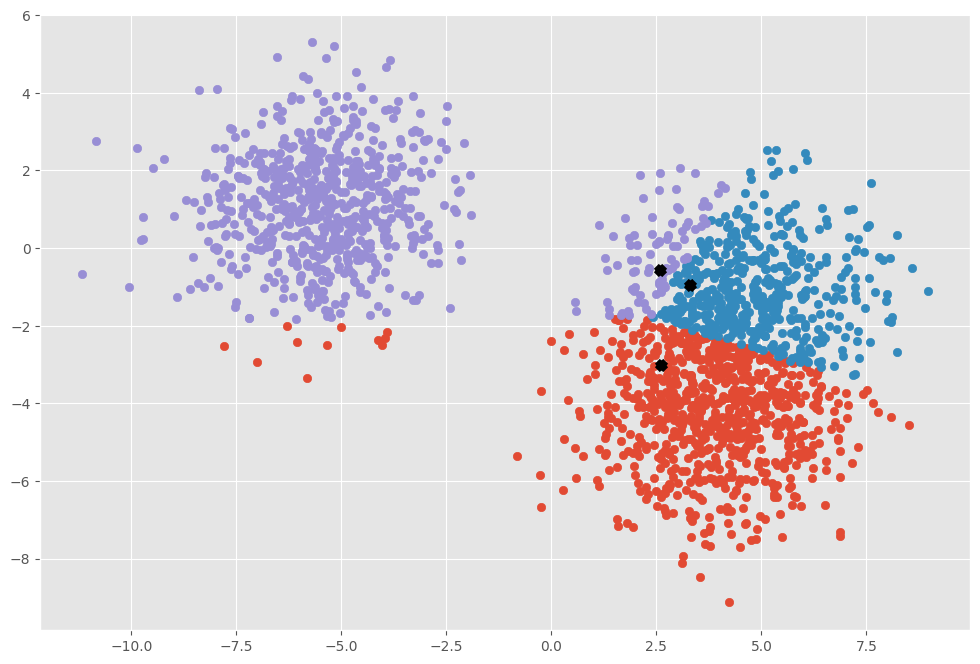

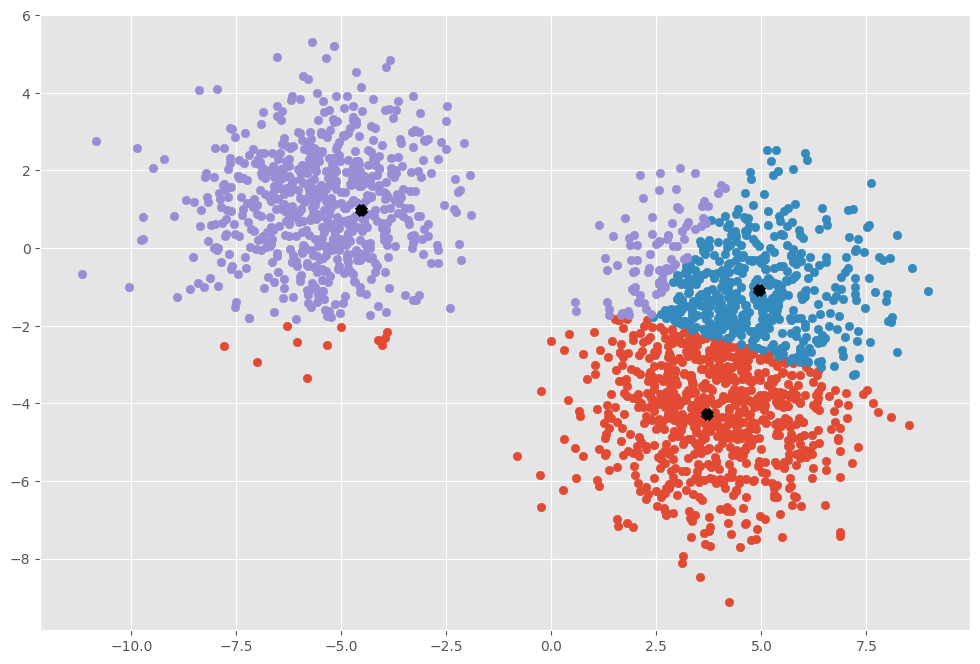

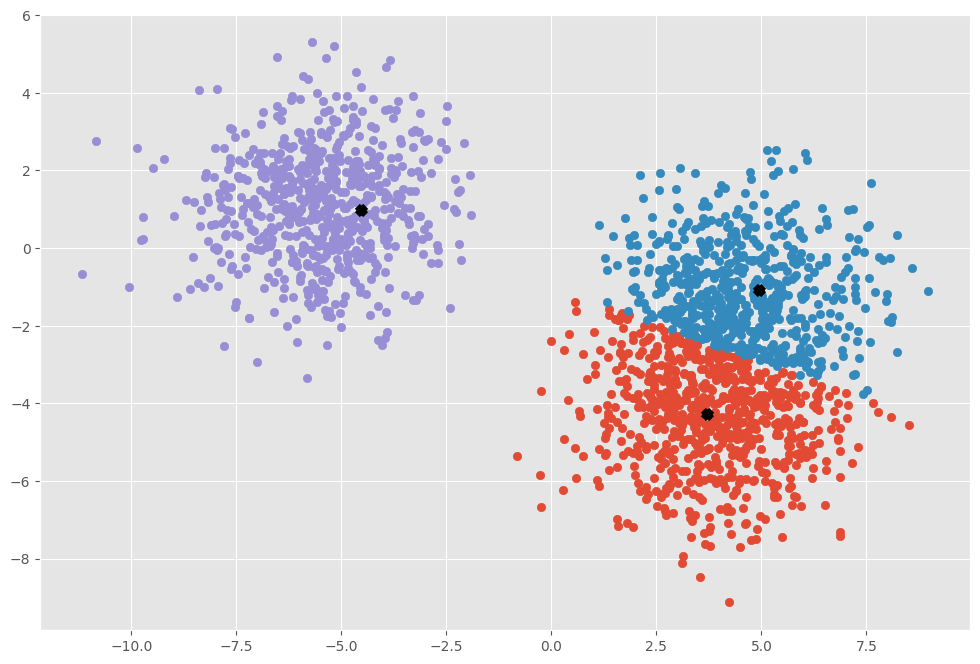

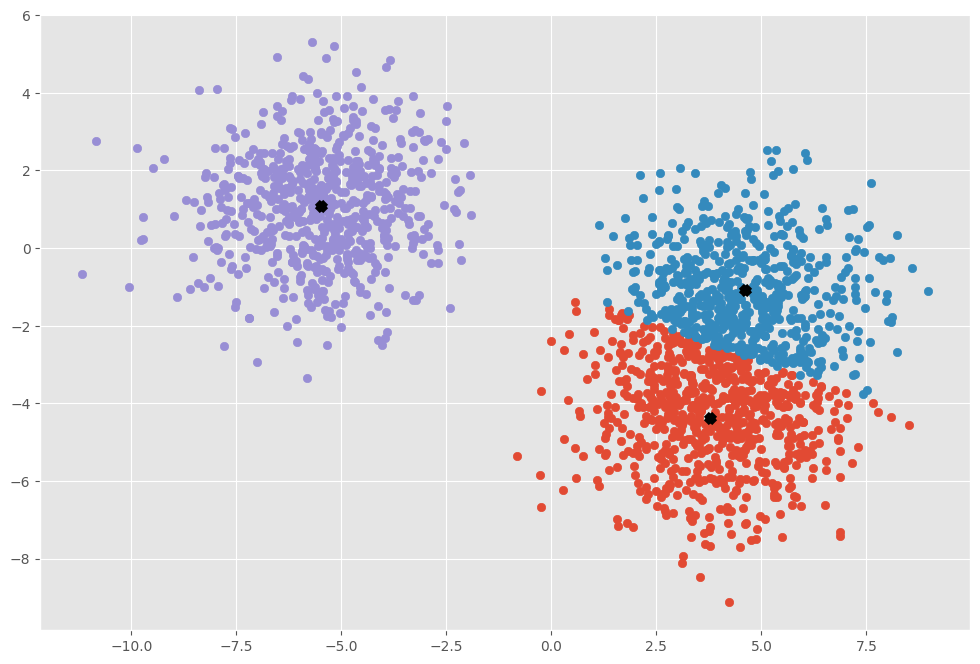

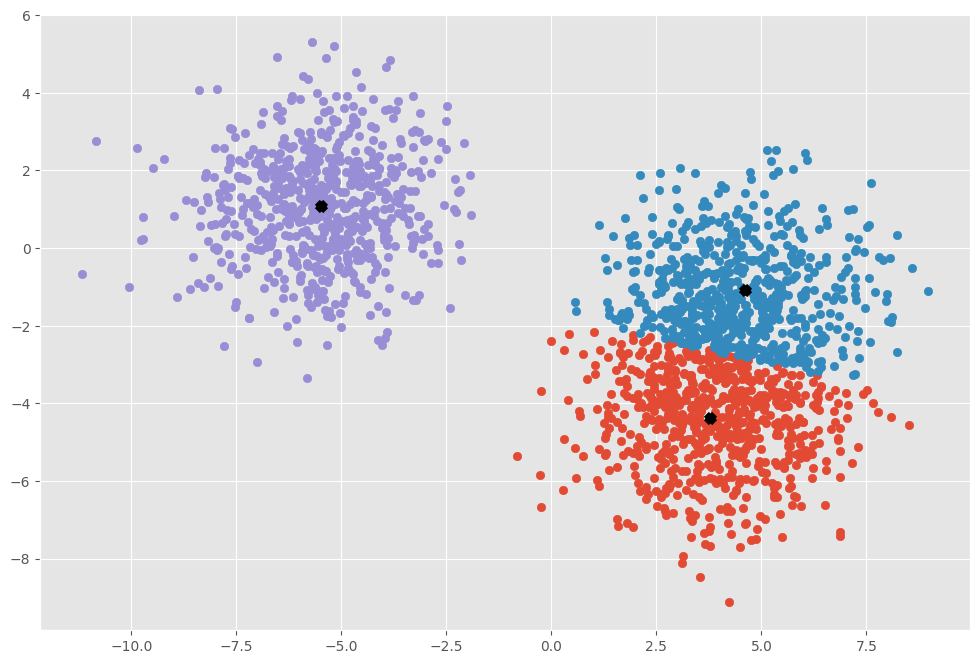

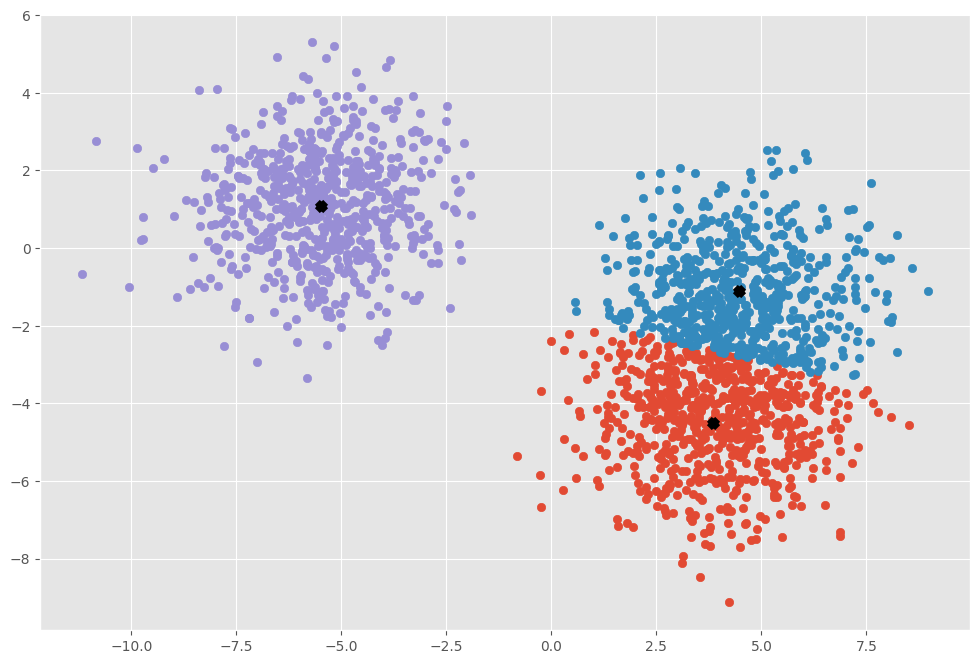

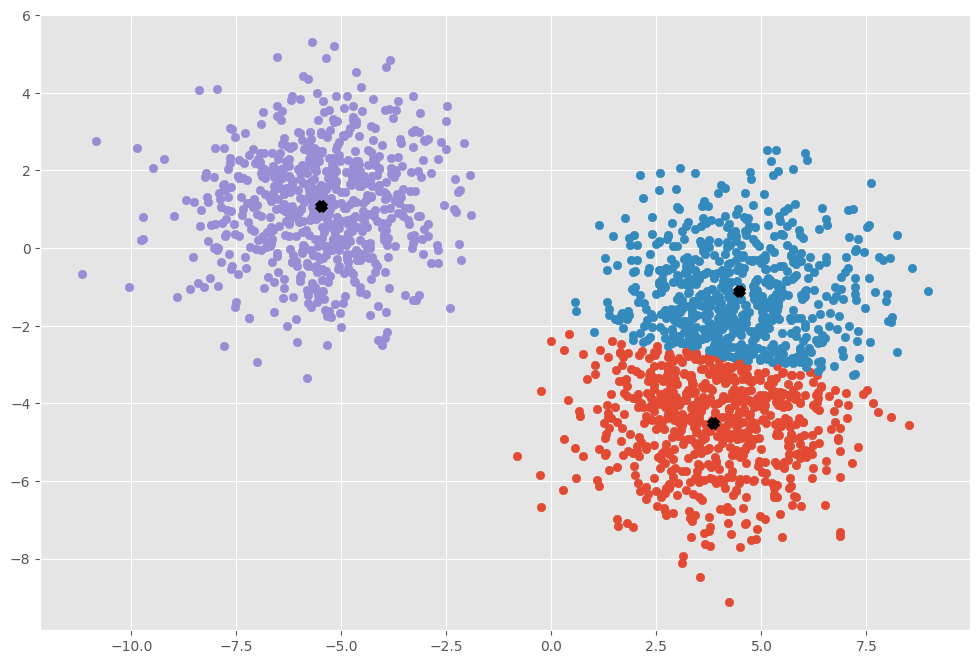

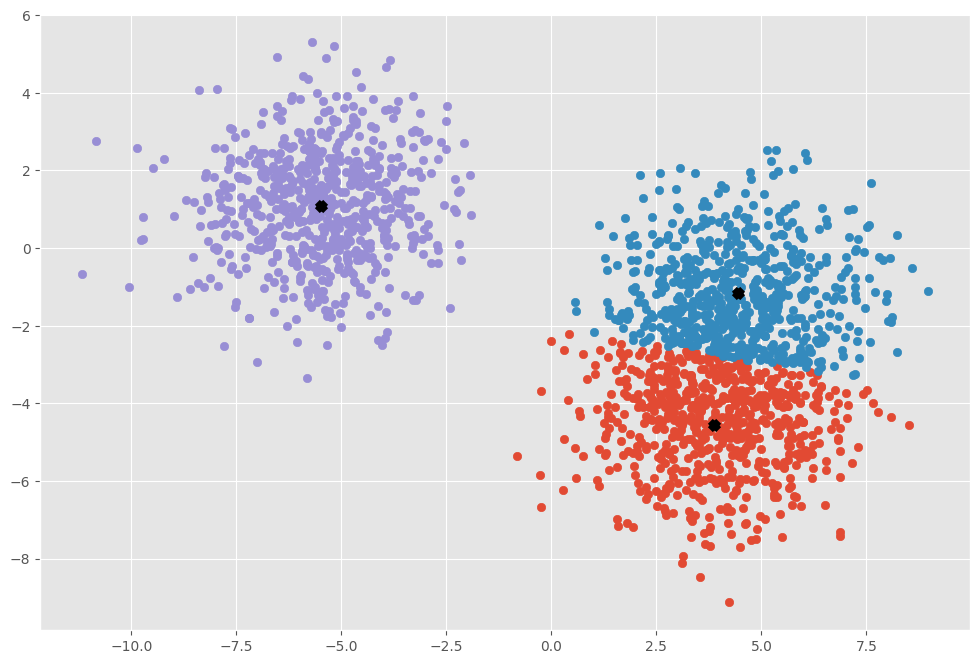

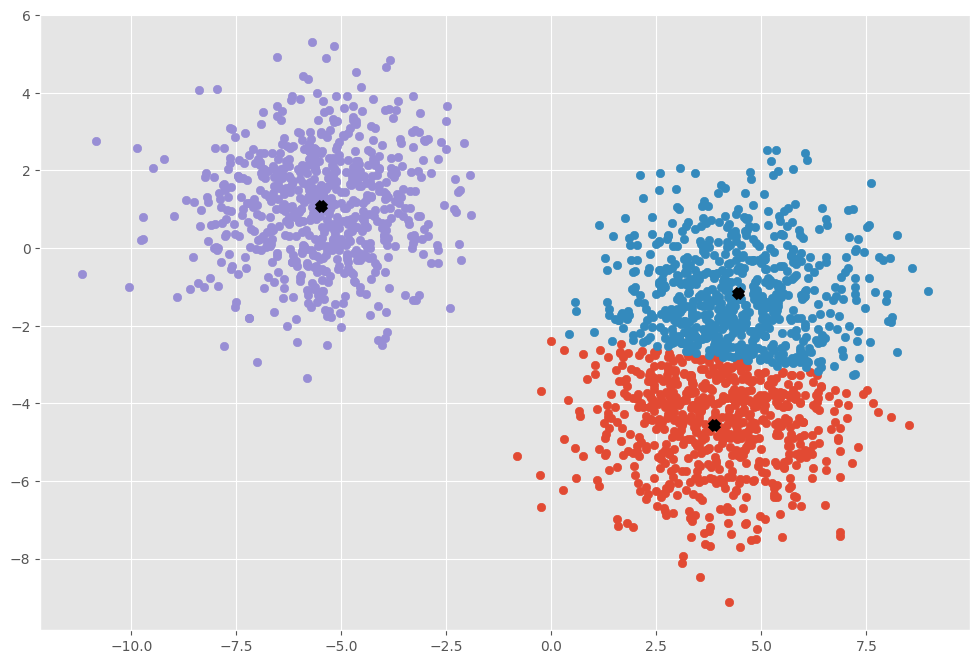

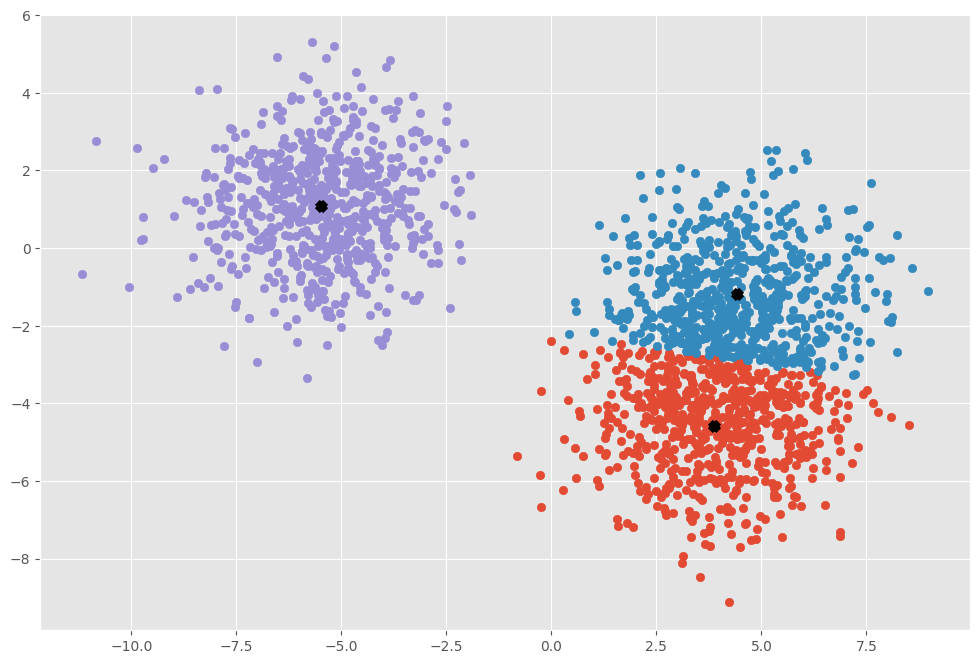

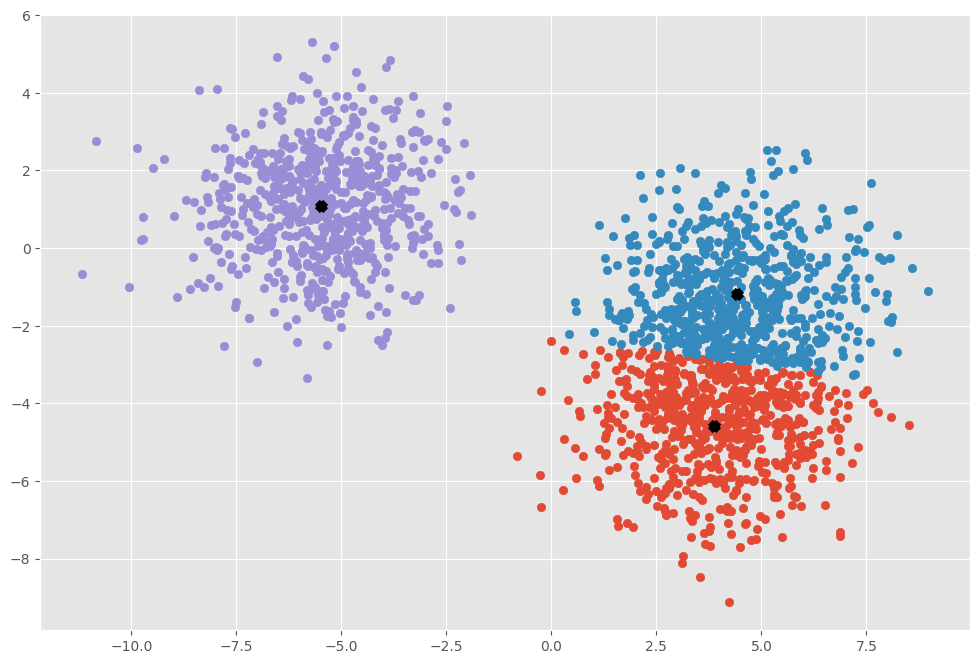

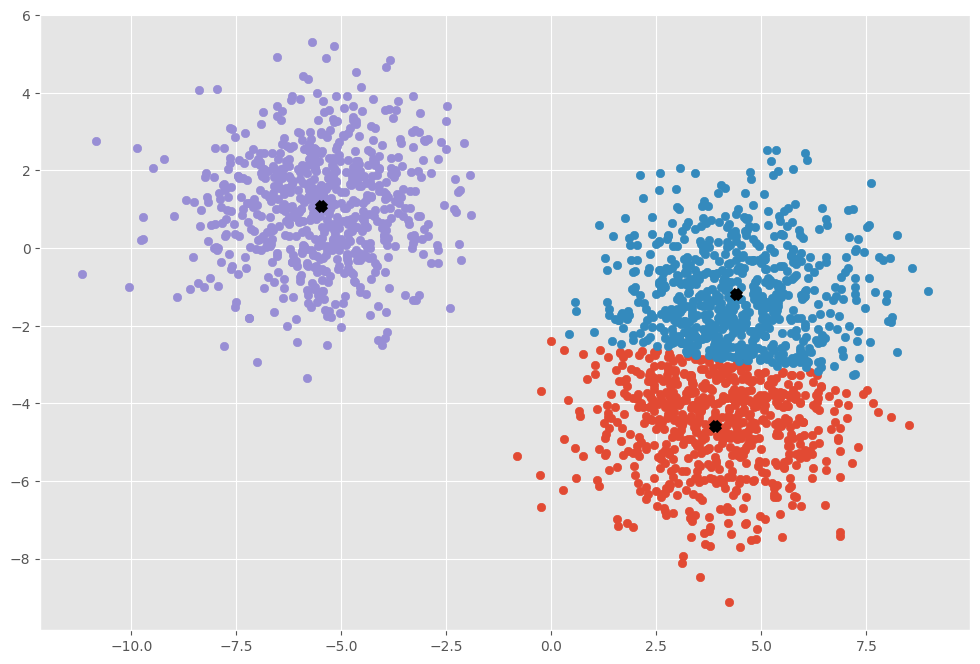

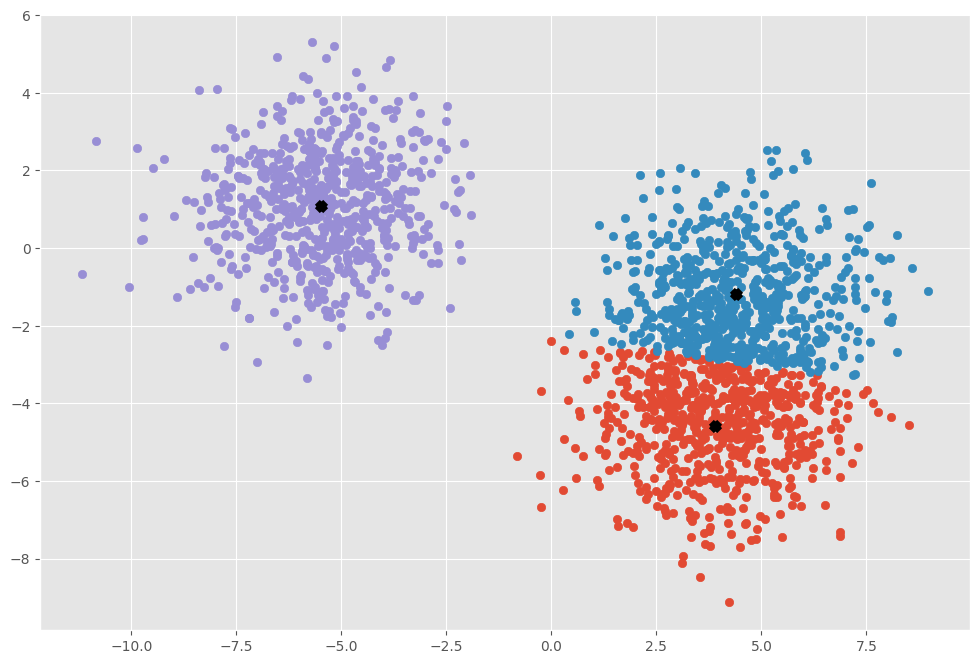

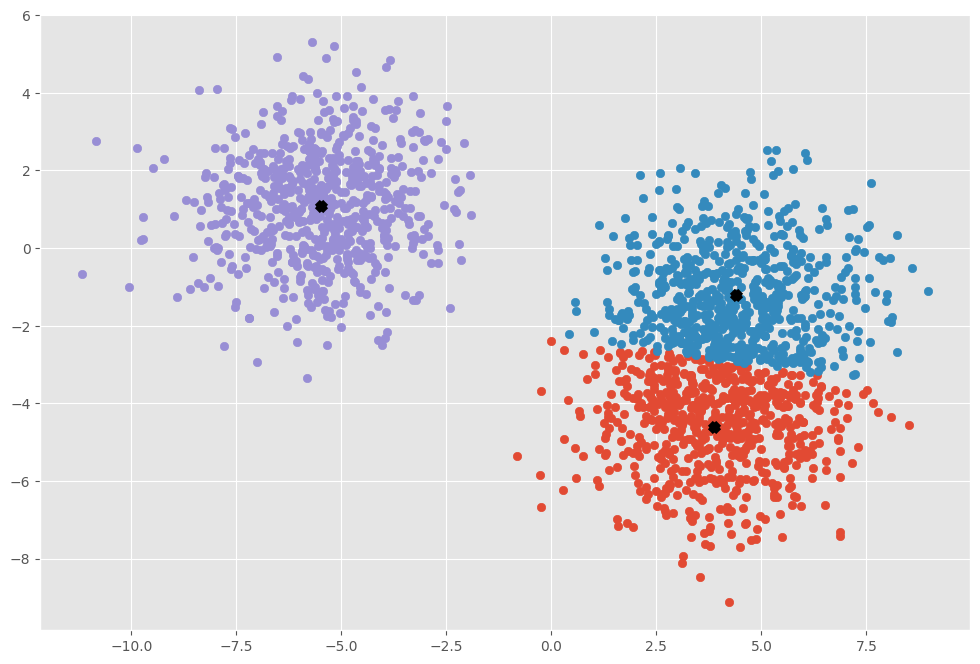

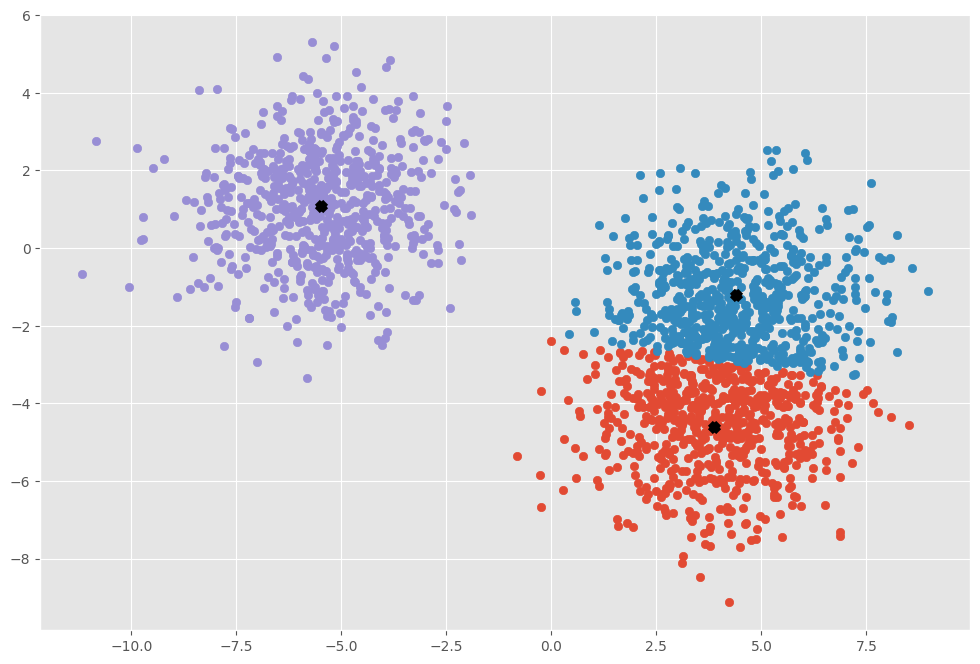

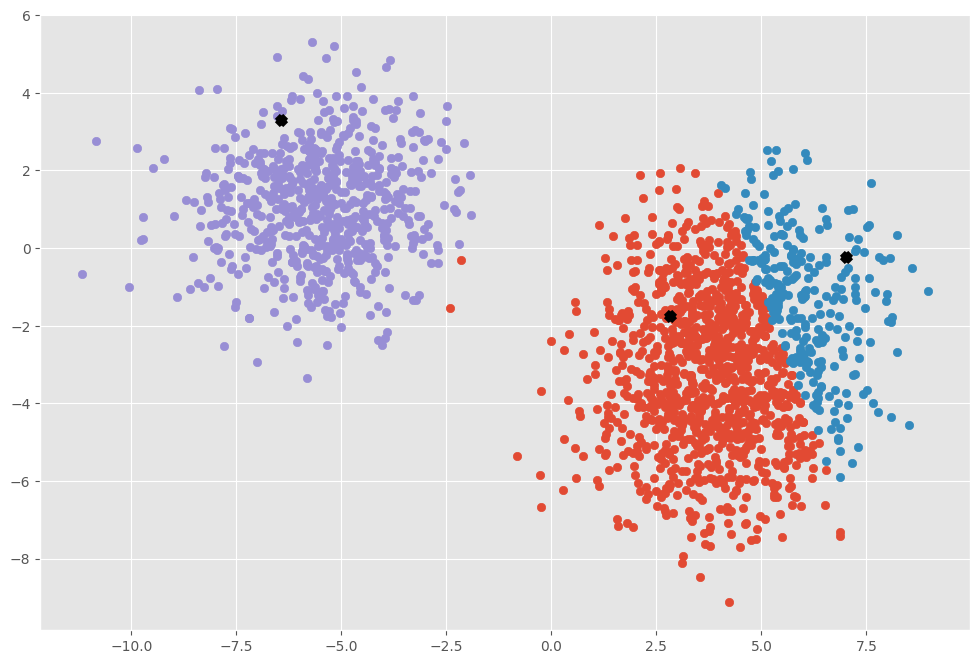

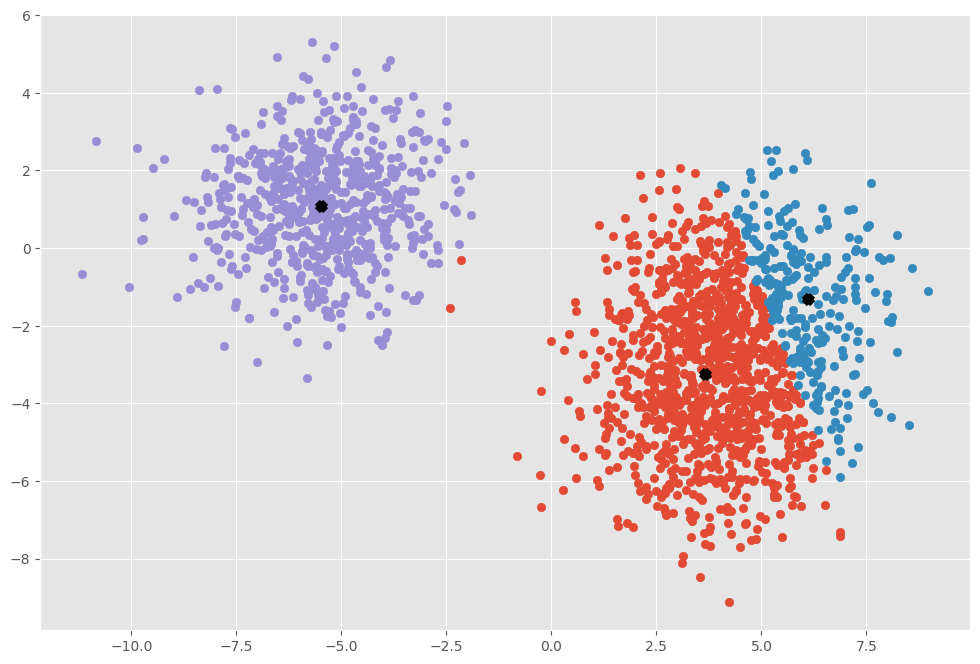

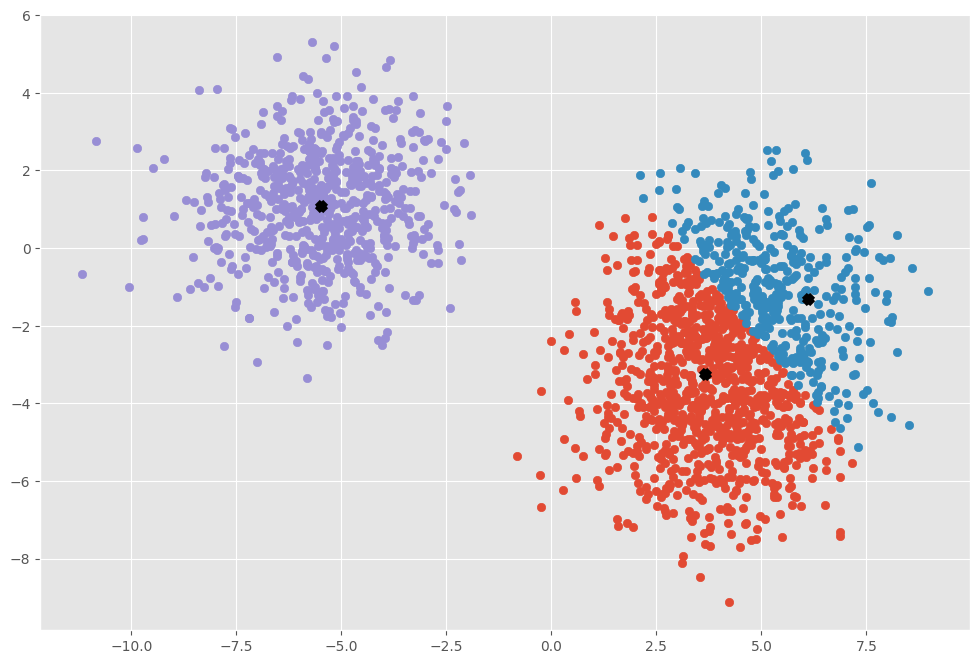

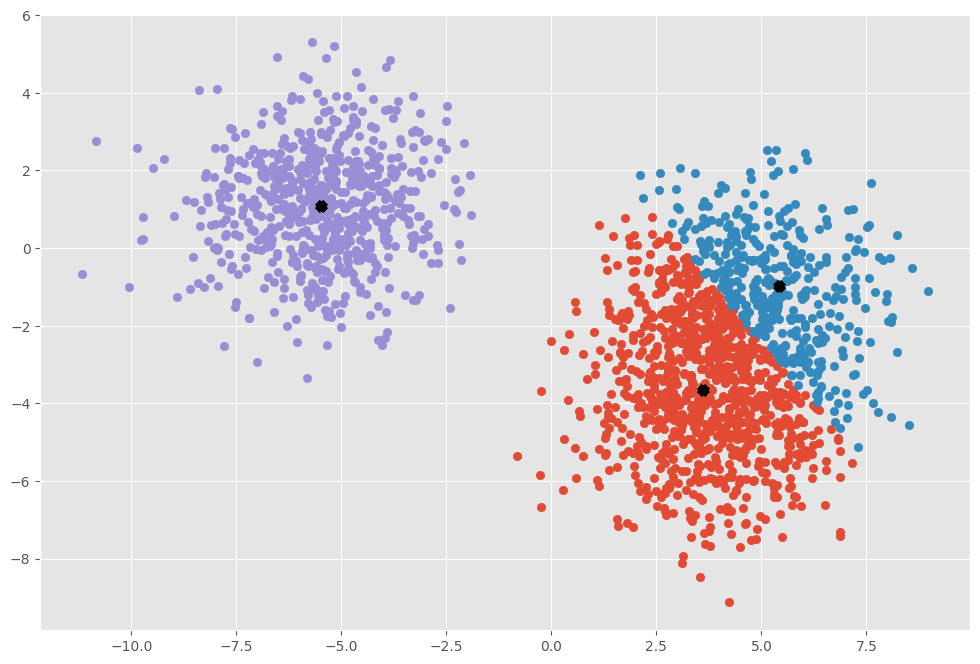

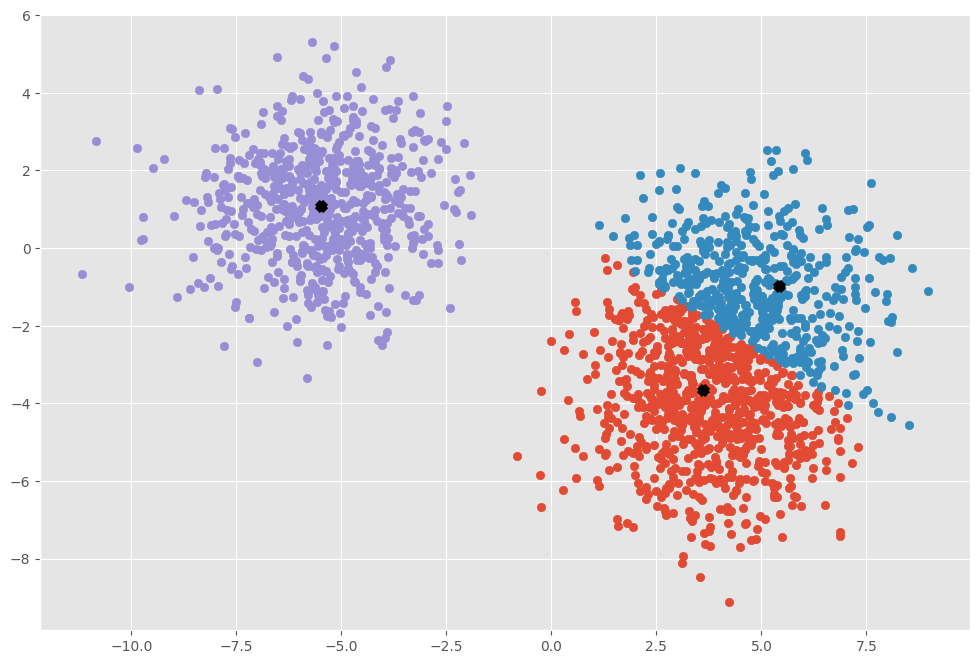

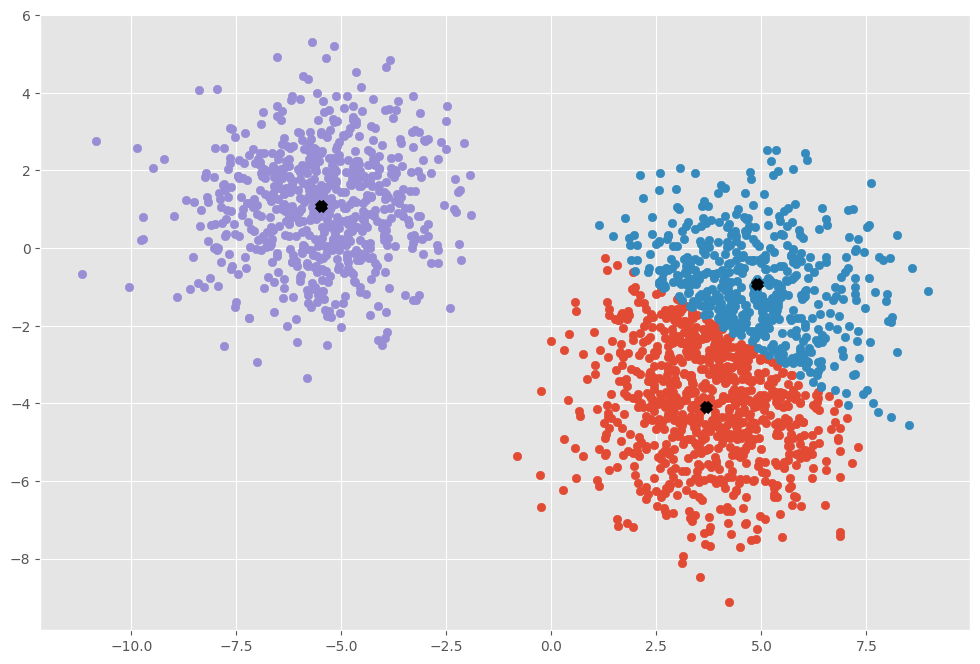

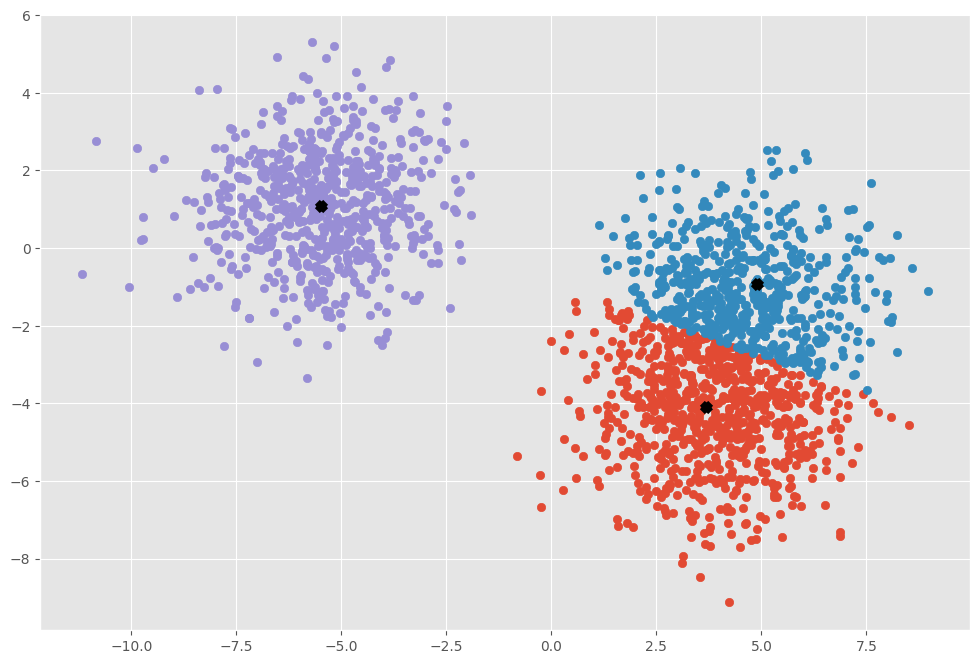

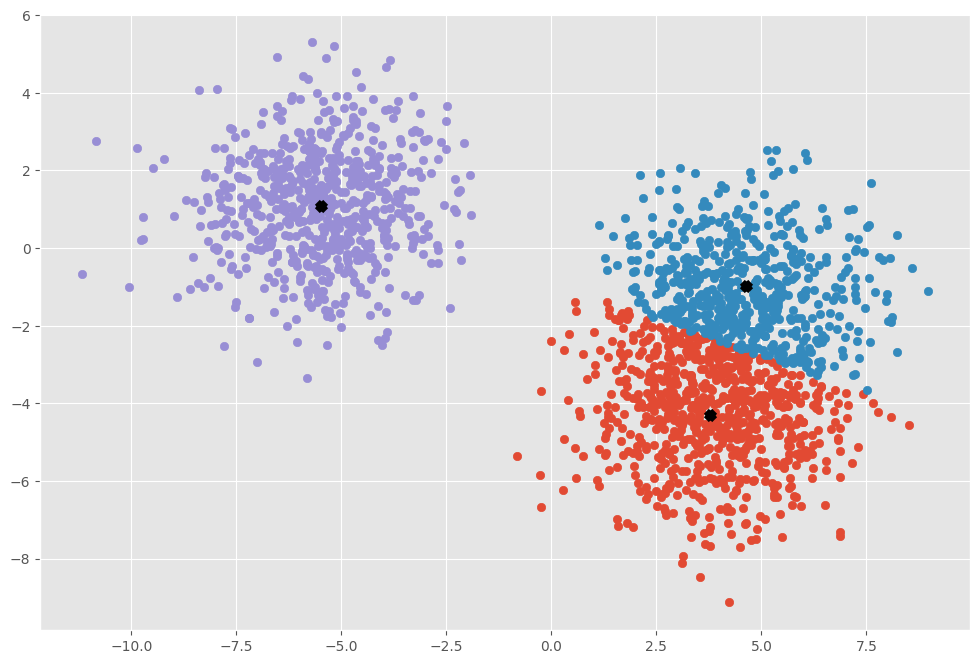

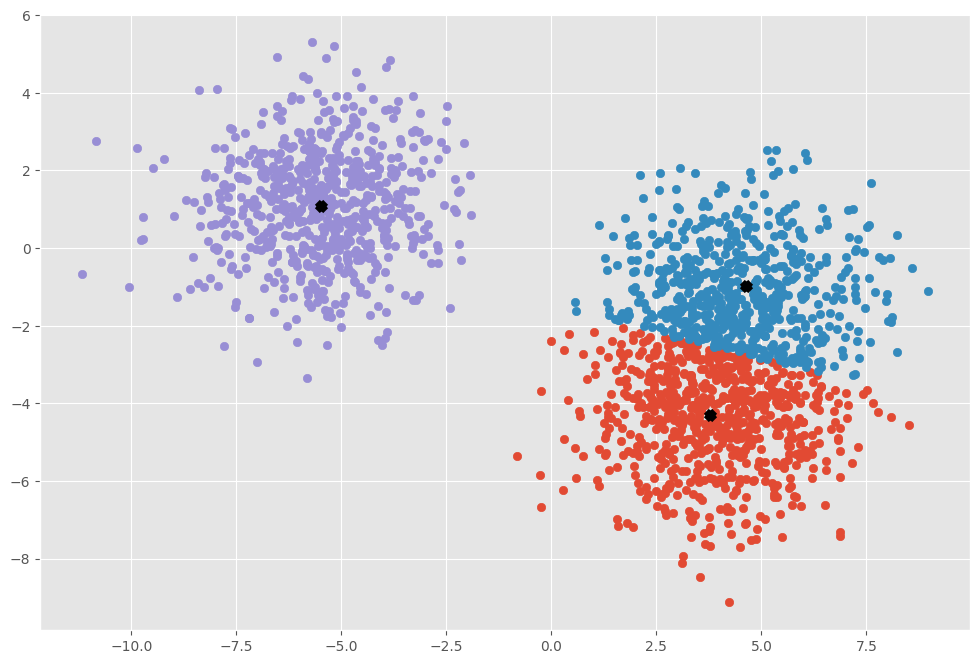

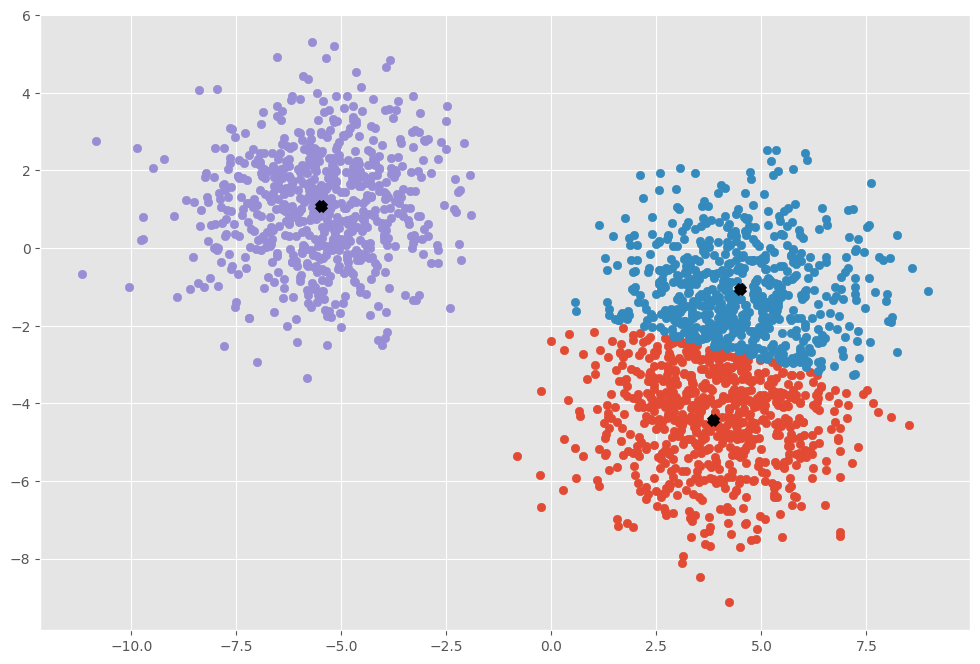

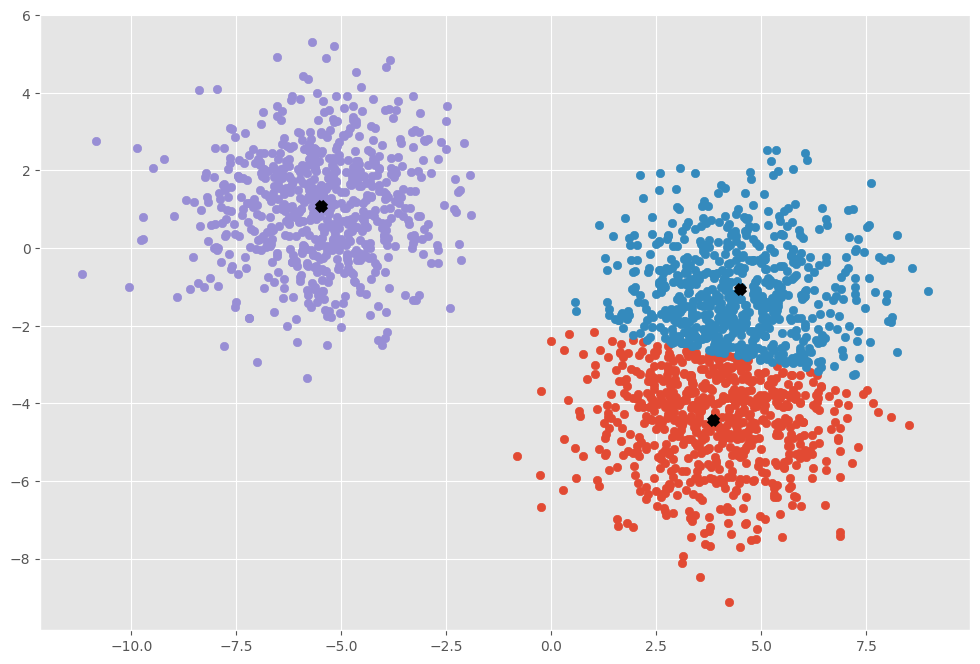

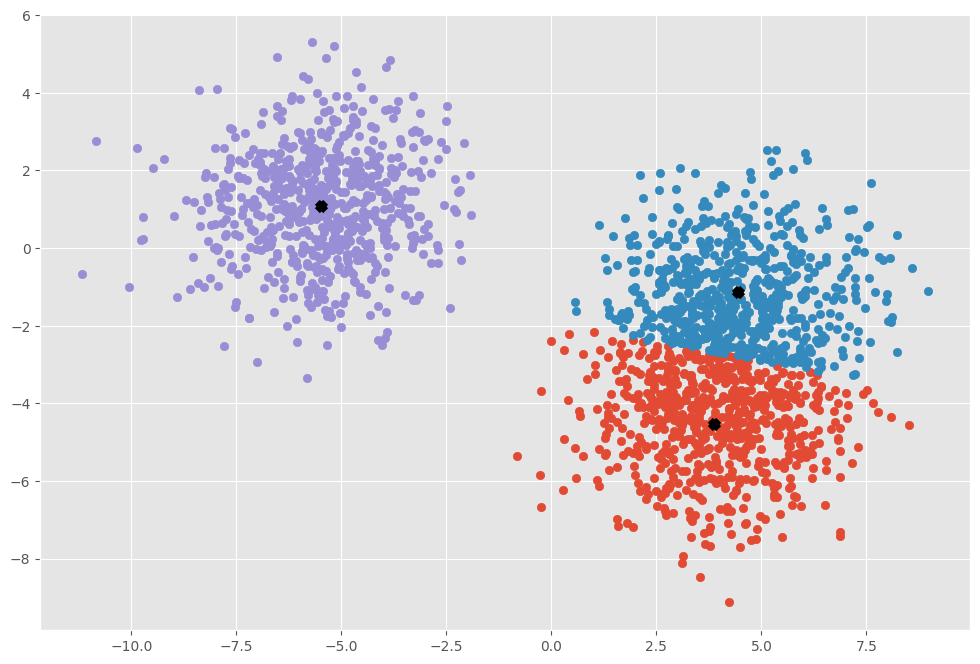

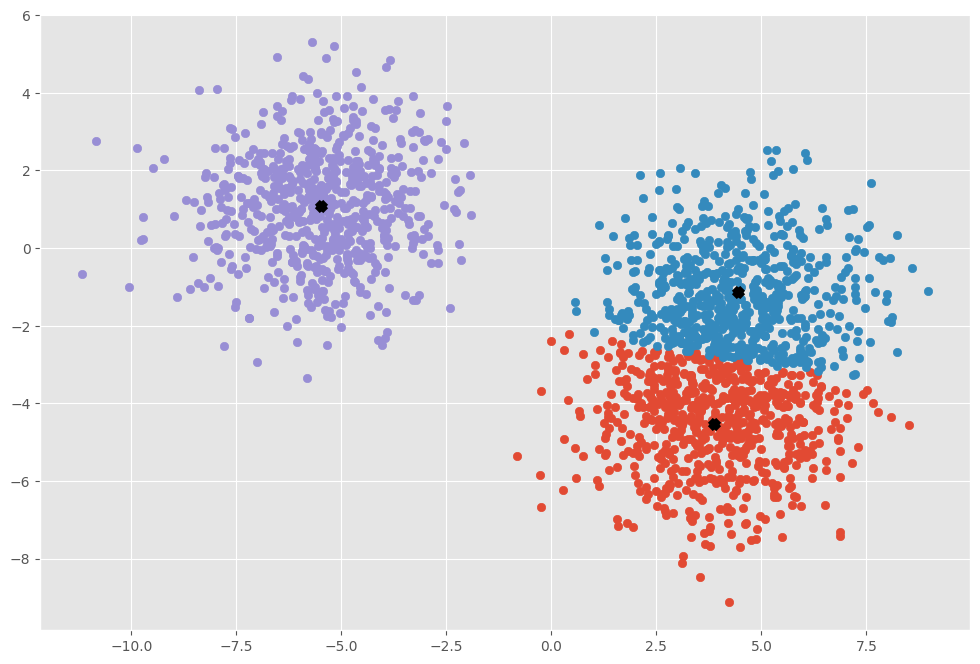

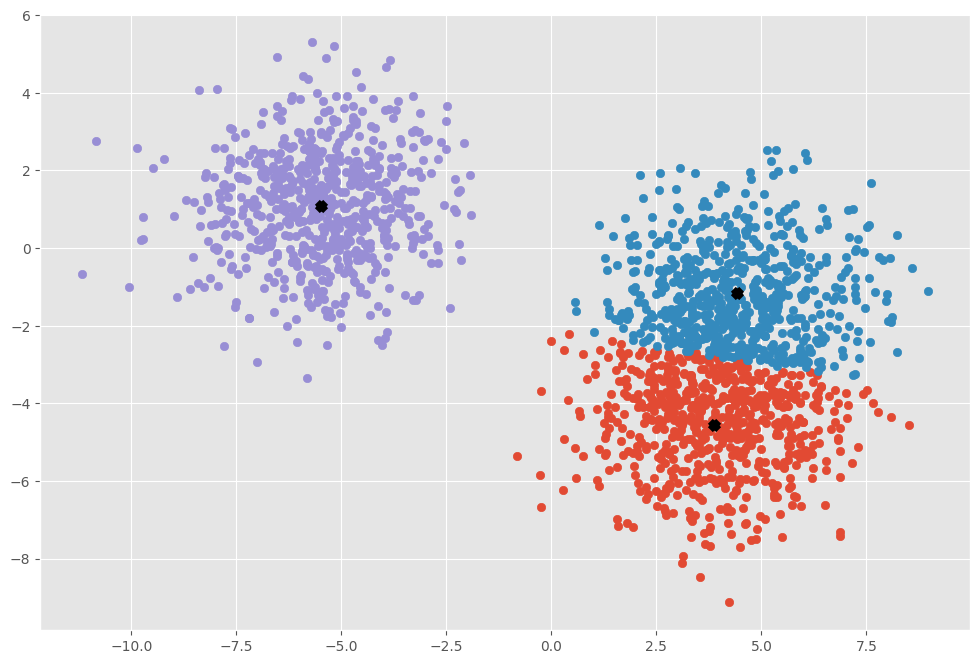

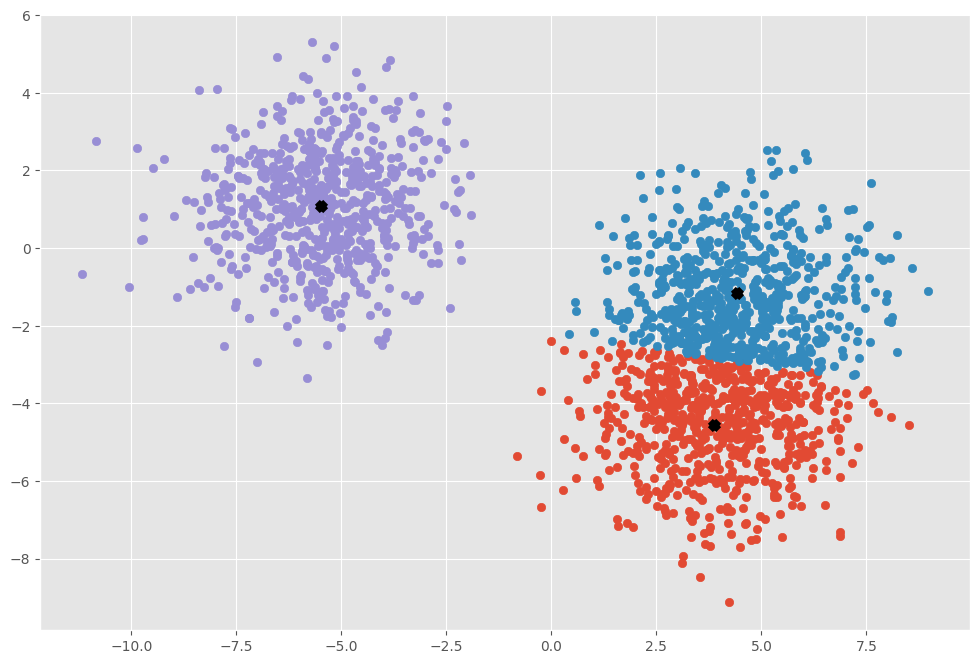

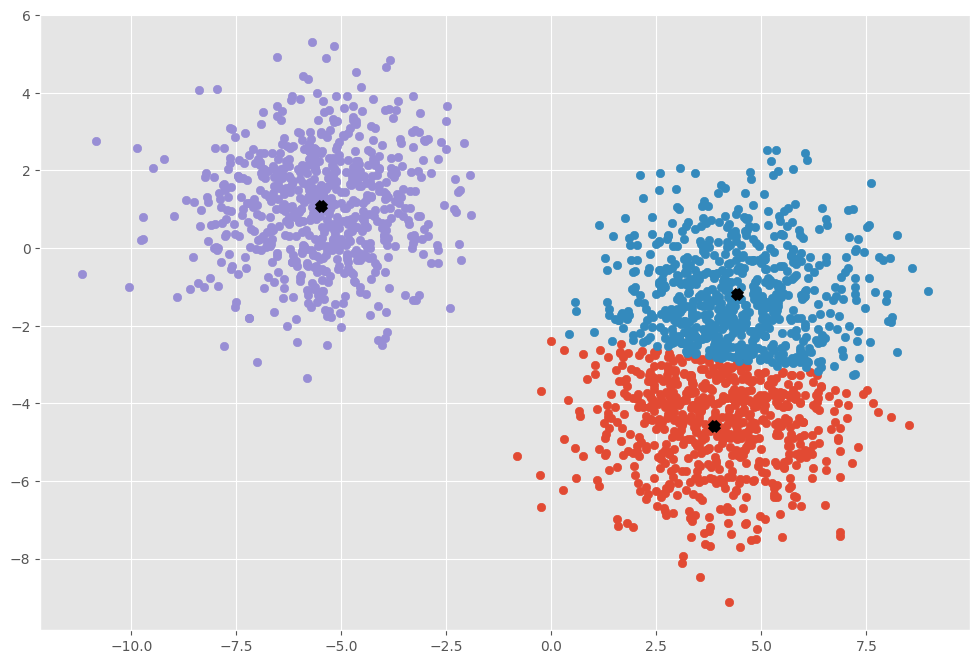

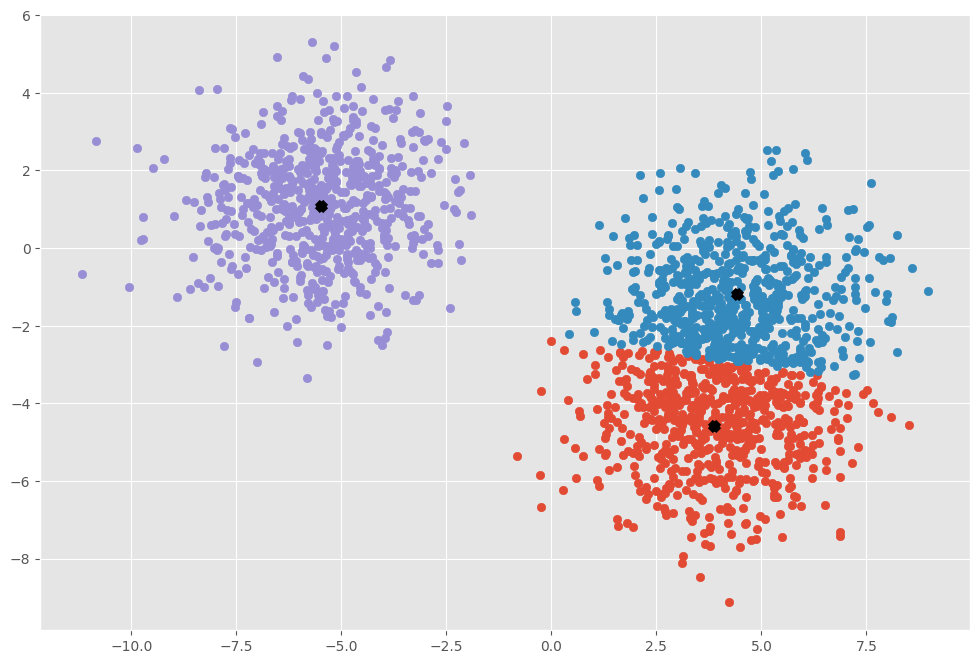

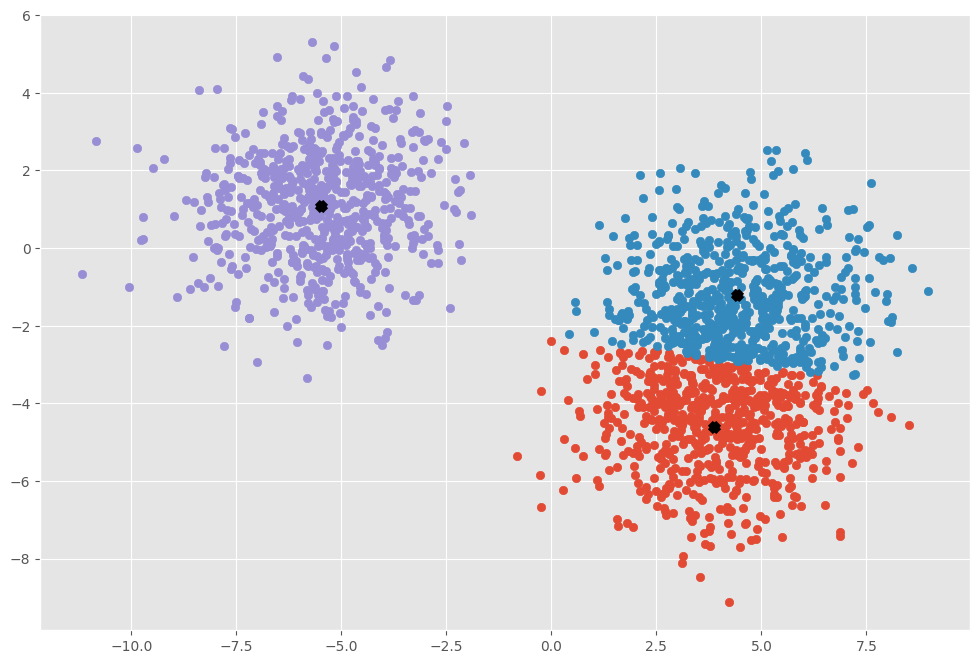

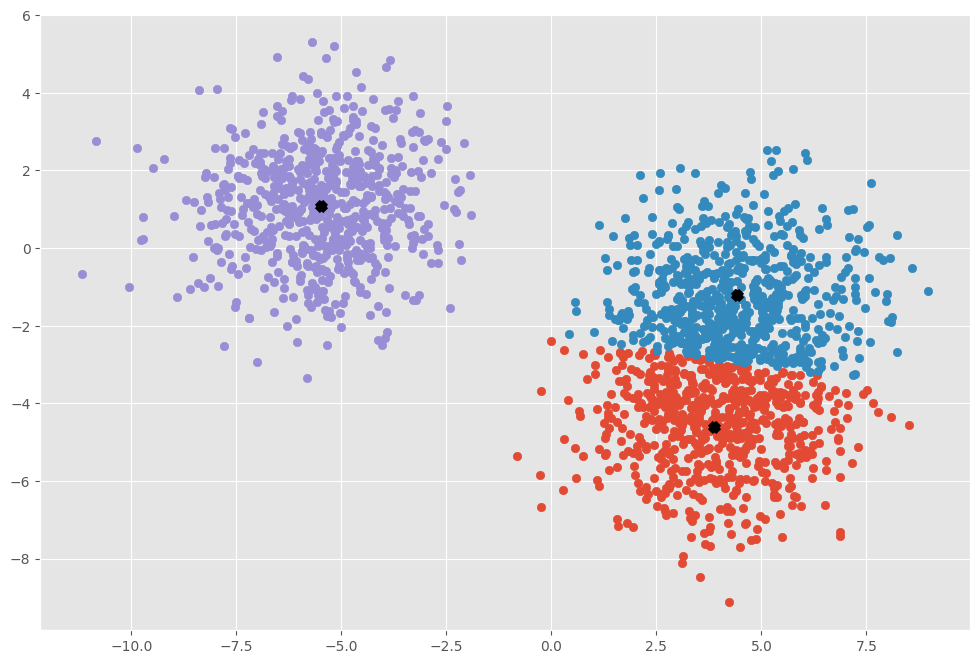

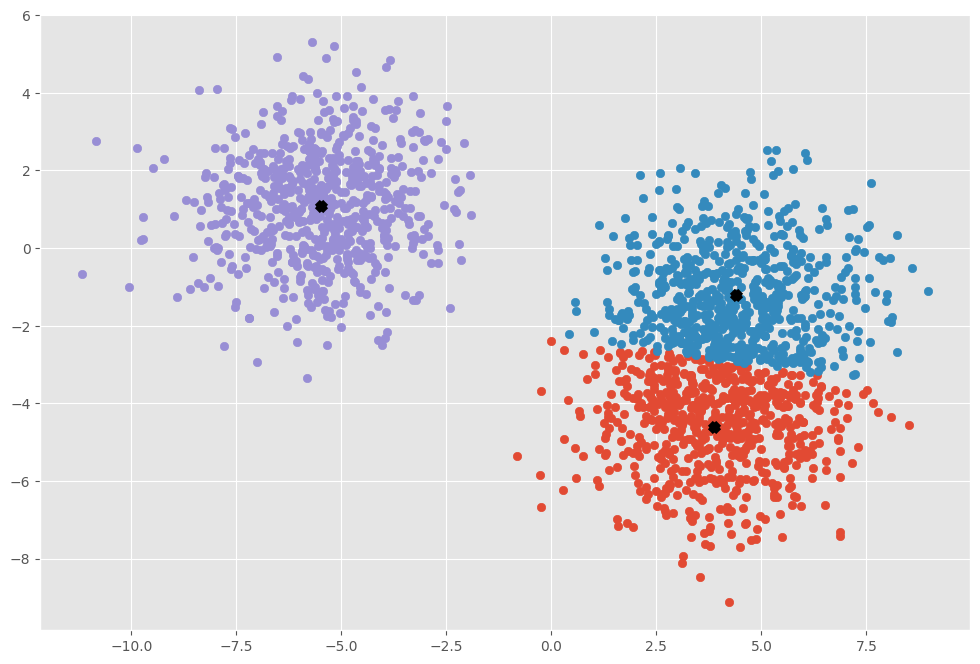

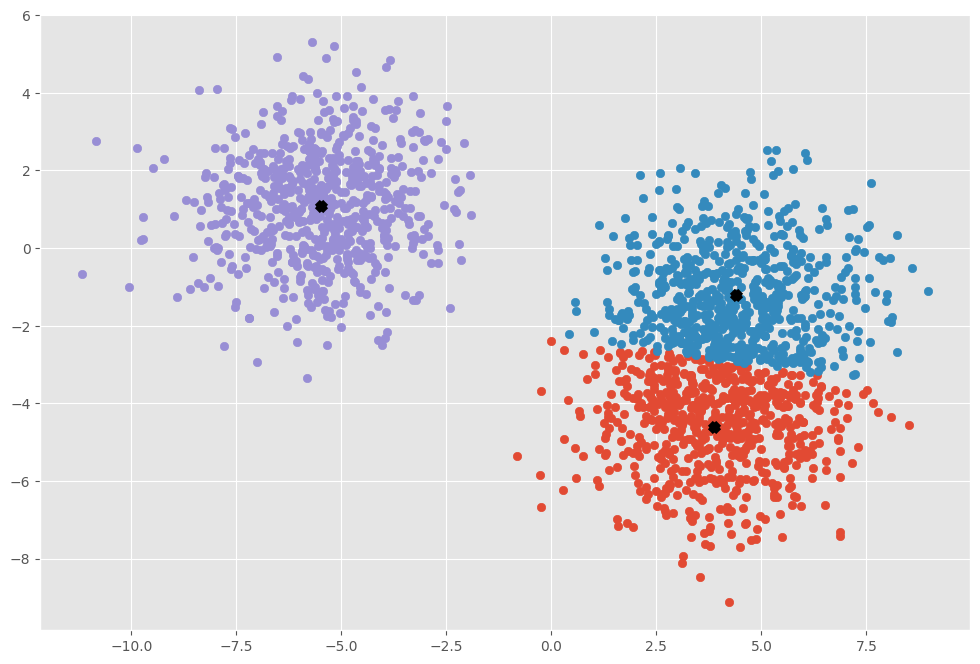

46

In [4]:
kmeans = KMeans(K=3, plot_steps=True)
kmeans.fit(X)
y_pred = kmeans.predict(X)
kmeans.n_iter_

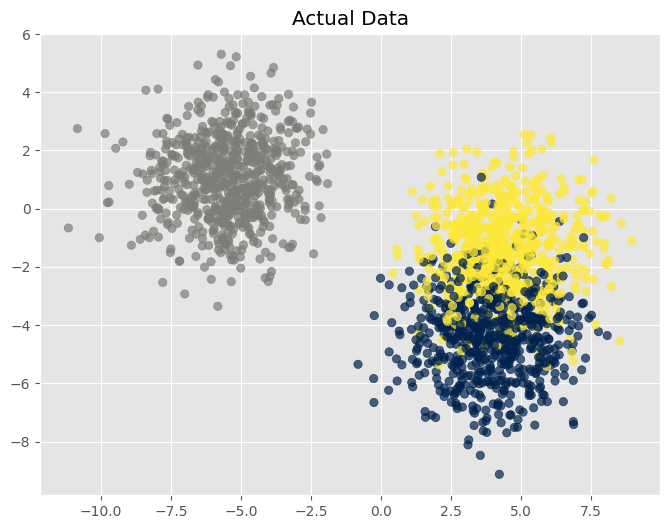

In [5]:
# Plot the clustered dataset
fig = plt.figure(figsize=(8, 6))
plt.scatter(
    X[:, 0],
    X[:, 1],
    c=y,
    cmap=plt.cm.cividis,
    alpha=0.7,
)
plt.title("Actual Data")
plt.show()

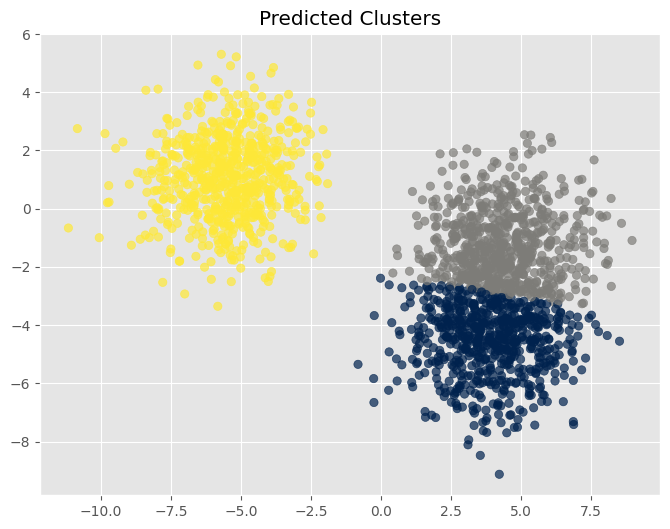

In [6]:
# Plot the clustered dataset
fig = plt.figure(figsize=(8, 6))
plt.scatter(
    X[:, 0],
    X[:, 1],
    c=y_pred,
    cmap=plt.cm.cividis,
    alpha=0.7,
)
plt.title("Predicted Clusters")
plt.show()

In [7]:
kmeans.centroids

array([[ 3.8823474 , -4.61021155],
       [ 4.40526364, -1.20304363],
       [-5.48468056,  1.08523053]])

In [8]:
new, old = kmeans.centroids, kmeans.centroids

kmeans._is_converged(new, old)

True

In [9]:
distances = [
    KMeans._calculate_euclidean_distance(point_a=new[i], point_b=old[i])
    for i in range(3)
]
distances

[0.0, 0.0, 0.0]